In [111]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import save_image
from tqdm.notebook import tqdm
from IPython.display import Image

%matplotlib inline

##### Environement Setup

In [112]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()
print(device)

img_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
lr = 0.0002
epochs = 200

cuda


##### Directory Setup

In [113]:
import os

DATASET_DIR = './dataset'
print(os.listdir(DATASET_DIR))
print(os.listdir(DATASET_DIR+'/images')[:10])

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

['images']
['000124.png', '000296.png', '000645.png', '000846.png', '000988.png', '000993.png', '001031.png', '001036.png', '001066.png', '001094.png']


#### Preprocessing

Some Functions

In [114]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
def show_images(images, nmax=64):
    _, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    imgs = denorm(images.detach()[:nmax])
    ax.imshow(make_grid(imgs, nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class MyDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

Train Dataset preparation 

In [115]:
train_dataset = ImageFolder(DATASET_DIR, transform=T.Compose([
    T.Resize(img_size),
    T.CenterCrop(img_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_data_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)

Show some train images (Batch) 

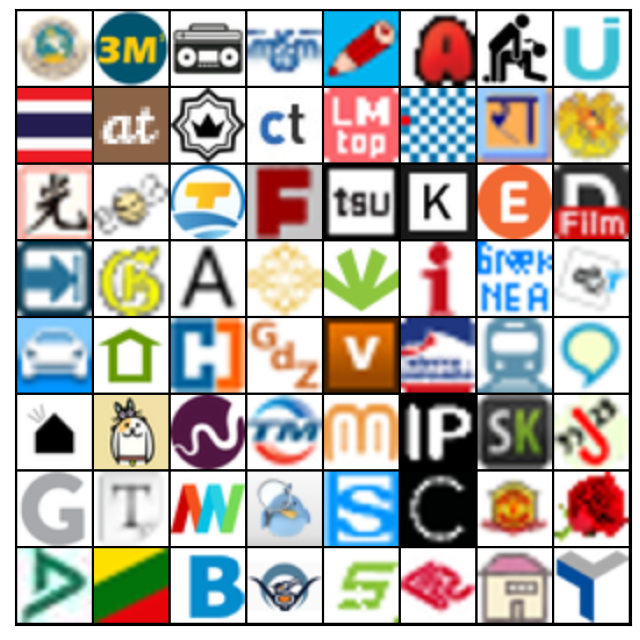

In [116]:
show_batch(train_data_loader)

In [117]:
# My DataLoader just put the dataset into the device (cuda in generale)
train_data_loader = MyDataLoader(train_data_loader, device)

Descriminator Architecture

In [118]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [119]:
discriminator = to_device(discriminator, device)

In [120]:
latent_size = 128

In [121]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


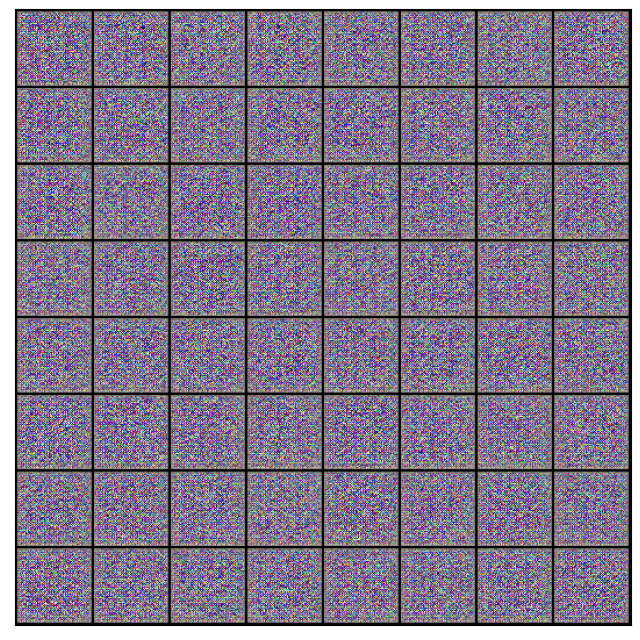

In [122]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [123]:
generator = to_device(generator, device)

In [124]:
# One train step for descriminator where we take a real_images batch
# then we get another fake images from the generator 
# and update descriminator wheights using the tow losses 
# (real images loss and the fake images loss)
# 1 means fake image and 0 means real image  
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score
# TO train the generator we give a noise vector to the generator and based on it 
# we will get an images and then pass it to the descriminator in order 
# to get some predictions (0 real or 1 fake) and calculate the loss  
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [125]:
# At Each Epoch we will see how good is our generator
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [126]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


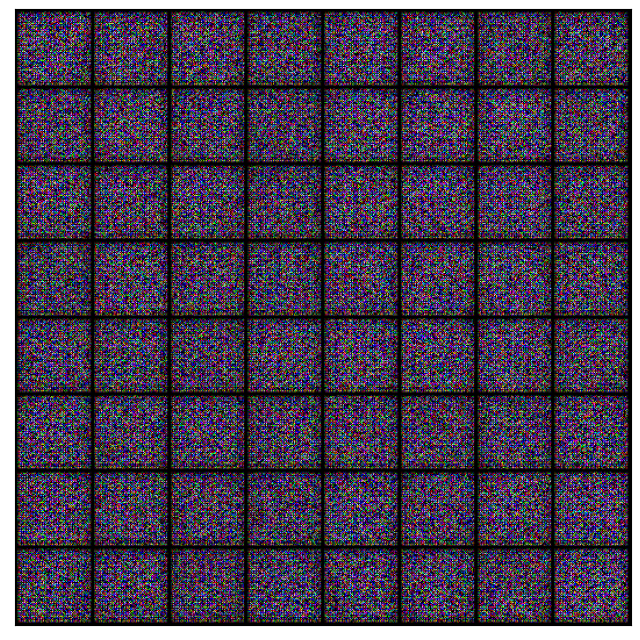

In [127]:
save_samples(0, fixed_latent)

In [128]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_data_loader):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [129]:
history = fit(epochs, lr)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1/200], loss_g: 15.3165, loss_d: 0.0146, real_score: 0.9858, fake_score: 0.0000
Saving generated-images-0001.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [2/200], loss_g: 18.1743, loss_d: 0.0400, real_score: 0.9619, fake_score: 0.0000
Saving generated-images-0002.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [3/200], loss_g: 8.9866, loss_d: 0.0186, real_score: 0.9825, fake_score: 0.0006
Saving generated-images-0003.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [4/200], loss_g: 4.6500, loss_d: 0.2313, real_score: 0.8437, fake_score: 0.0180
Saving generated-images-0004.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [5/200], loss_g: 10.1281, loss_d: 0.1648, real_score: 0.9990, fake_score: 0.1415
Saving generated-images-0005.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [6/200], loss_g: 2.9715, loss_d: 0.5827, real_score: 0.7357, fake_score: 0.2061
Saving generated-images-0006.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [7/200], loss_g: 4.4870, loss_d: 0.2898, real_score: 0.9160, fake_score: 0.1711
Saving generated-images-0007.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [8/200], loss_g: 2.1837, loss_d: 0.3178, real_score: 0.8205, fake_score: 0.1050
Saving generated-images-0008.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [9/200], loss_g: 0.3013, loss_d: 0.5556, real_score: 0.6658, fake_score: 0.0830
Saving generated-images-0009.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [10/200], loss_g: 0.1591, loss_d: 1.4076, real_score: 0.4193, fake_score: 0.1594
Saving generated-images-0010.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [11/200], loss_g: 0.4145, loss_d: 1.7454, real_score: 0.2292, fake_score: 0.1084
Saving generated-images-0011.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [12/200], loss_g: 2.1413, loss_d: 0.3956, real_score: 0.7765, fake_score: 0.0917
Saving generated-images-0012.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [13/200], loss_g: 1.0836, loss_d: 0.5449, real_score: 0.6882, fake_score: 0.1198
Saving generated-images-0013.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [14/200], loss_g: 5.8413, loss_d: 1.4356, real_score: 0.8984, fake_score: 0.6183
Saving generated-images-0014.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [15/200], loss_g: 3.7404, loss_d: 0.1313, real_score: 0.9741, fake_score: 0.0960
Saving generated-images-0015.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [16/200], loss_g: 2.0318, loss_d: 0.5353, real_score: 0.7294, fake_score: 0.1129
Saving generated-images-0016.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [17/200], loss_g: 4.1681, loss_d: 0.3695, real_score: 0.9653, fake_score: 0.2649
Saving generated-images-0017.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [18/200], loss_g: 1.5990, loss_d: 1.2057, real_score: 0.3700, fake_score: 0.0243
Saving generated-images-0018.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [19/200], loss_g: 2.7450, loss_d: 0.4116, real_score: 0.8020, fake_score: 0.1571
Saving generated-images-0019.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [20/200], loss_g: 4.2027, loss_d: 0.0975, real_score: 0.9760, fake_score: 0.0688
Saving generated-images-0020.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [21/200], loss_g: 2.0436, loss_d: 0.7312, real_score: 0.7176, fake_score: 0.3074
Saving generated-images-0021.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [22/200], loss_g: 2.3080, loss_d: 0.2950, real_score: 0.9220, fake_score: 0.1792
Saving generated-images-0022.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [23/200], loss_g: 0.1912, loss_d: 1.9985, real_score: 0.2028, fake_score: 0.0651
Saving generated-images-0023.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [24/200], loss_g: 3.4513, loss_d: 0.2318, real_score: 0.9020, fake_score: 0.1088
Saving generated-images-0024.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [25/200], loss_g: 3.7514, loss_d: 0.3122, real_score: 0.8996, fake_score: 0.1789
Saving generated-images-0025.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [26/200], loss_g: 0.5191, loss_d: 1.4959, real_score: 0.2811, fake_score: 0.0068
Saving generated-images-0026.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [27/200], loss_g: 3.3075, loss_d: 0.1370, real_score: 0.9002, fake_score: 0.0300
Saving generated-images-0027.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [28/200], loss_g: 0.2495, loss_d: 0.9732, real_score: 0.5124, fake_score: 0.1812
Saving generated-images-0028.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [29/200], loss_g: 1.4737, loss_d: 1.2834, real_score: 0.3601, fake_score: 0.0901
Saving generated-images-0029.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [30/200], loss_g: 0.0602, loss_d: 1.3430, real_score: 0.3586, fake_score: 0.0527
Saving generated-images-0030.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [31/200], loss_g: 3.4501, loss_d: 0.4403, real_score: 0.9516, fake_score: 0.3040
Saving generated-images-0031.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [32/200], loss_g: 3.3863, loss_d: 0.2192, real_score: 0.9469, fake_score: 0.1463
Saving generated-images-0032.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [33/200], loss_g: 1.5711, loss_d: 1.0276, real_score: 0.6816, fake_score: 0.4359
Saving generated-images-0033.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [34/200], loss_g: 1.3918, loss_d: 0.3882, real_score: 0.8399, fake_score: 0.1645
Saving generated-images-0034.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [35/200], loss_g: 2.0809, loss_d: 0.6758, real_score: 0.7099, fake_score: 0.2470
Saving generated-images-0035.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [36/200], loss_g: 0.0634, loss_d: 0.8025, real_score: 0.5270, fake_score: 0.0262
Saving generated-images-0036.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [37/200], loss_g: 1.4019, loss_d: 0.3008, real_score: 0.7847, fake_score: 0.0311
Saving generated-images-0037.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [38/200], loss_g: 3.7899, loss_d: 0.0502, real_score: 0.9785, fake_score: 0.0277
Saving generated-images-0038.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [39/200], loss_g: 0.0042, loss_d: 1.6995, real_score: 0.2825, fake_score: 0.0575
Saving generated-images-0039.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [40/200], loss_g: 2.0931, loss_d: 0.2423, real_score: 0.8737, fake_score: 0.0929
Saving generated-images-0040.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [41/200], loss_g: 1.0778, loss_d: 0.4248, real_score: 0.6826, fake_score: 0.0343
Saving generated-images-0041.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [42/200], loss_g: 2.4486, loss_d: 0.4723, real_score: 0.8455, fake_score: 0.2406
Saving generated-images-0042.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [43/200], loss_g: 0.6326, loss_d: 0.4748, real_score: 0.6738, fake_score: 0.0102
Saving generated-images-0043.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [44/200], loss_g: 3.6652, loss_d: 0.2367, real_score: 0.9537, fake_score: 0.1671
Saving generated-images-0044.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [45/200], loss_g: 0.0952, loss_d: 0.8212, real_score: 0.5064, fake_score: 0.0240
Saving generated-images-0045.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [46/200], loss_g: 0.1406, loss_d: 2.4619, real_score: 0.1079, fake_score: 0.0488
Saving generated-images-0046.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [47/200], loss_g: 2.7512, loss_d: 0.1734, real_score: 0.9102, fake_score: 0.0704
Saving generated-images-0047.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [48/200], loss_g: 0.3757, loss_d: 0.3708, real_score: 0.7481, fake_score: 0.0178
Saving generated-images-0048.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [49/200], loss_g: 2.6407, loss_d: 0.2402, real_score: 0.8803, fake_score: 0.0959
Saving generated-images-0049.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [50/200], loss_g: 7.0439, loss_d: 8.5444, real_score: 0.0003, fake_score: 0.0000
Saving generated-images-0050.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [51/200], loss_g: 0.0002, loss_d: 1.3938, real_score: 0.3483, fake_score: 0.1220
Saving generated-images-0051.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [52/200], loss_g: 2.5733, loss_d: 0.1280, real_score: 0.9301, fake_score: 0.0502
Saving generated-images-0052.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [53/200], loss_g: 0.8973, loss_d: 0.7277, real_score: 0.6375, fake_score: 0.2148
Saving generated-images-0053.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [54/200], loss_g: 0.4910, loss_d: 0.7350, real_score: 0.5858, fake_score: 0.1556
Saving generated-images-0054.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [55/200], loss_g: 1.5888, loss_d: 0.2785, real_score: 0.8266, fake_score: 0.0600
Saving generated-images-0055.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [56/200], loss_g: 0.0924, loss_d: 0.6534, real_score: 0.5835, fake_score: 0.0358
Saving generated-images-0056.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [57/200], loss_g: 0.5077, loss_d: 0.2856, real_score: 0.7889, fake_score: 0.0279
Saving generated-images-0057.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [58/200], loss_g: 0.0014, loss_d: 3.0264, real_score: 0.0784, fake_score: 0.0246
Saving generated-images-0058.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [59/200], loss_g: 1.4321, loss_d: 0.6961, real_score: 0.6806, fake_score: 0.2215
Saving generated-images-0059.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [60/200], loss_g: 0.0037, loss_d: 1.4095, real_score: 0.2686, fake_score: 0.0142
Saving generated-images-0060.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [61/200], loss_g: 5.0994, loss_d: 0.1659, real_score: 0.8654, fake_score: 0.0105
Saving generated-images-0061.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [62/200], loss_g: 1.2059, loss_d: 0.4968, real_score: 0.6263, fake_score: 0.0048
Saving generated-images-0062.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [63/200], loss_g: 1.1337, loss_d: 0.3695, real_score: 0.7564, fake_score: 0.0469
Saving generated-images-0063.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [64/200], loss_g: 0.6916, loss_d: 0.2539, real_score: 0.7910, fake_score: 0.0098
Saving generated-images-0064.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [65/200], loss_g: 4.3901, loss_d: 0.0634, real_score: 0.9971, fake_score: 0.0578
Saving generated-images-0065.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [66/200], loss_g: 4.3187, loss_d: 0.0610, real_score: 0.9890, fake_score: 0.0479
Saving generated-images-0066.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [67/200], loss_g: 2.0080, loss_d: 0.6213, real_score: 0.6792, fake_score: 0.1792
Saving generated-images-0067.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [68/200], loss_g: 3.0607, loss_d: 0.1452, real_score: 0.8976, fake_score: 0.0341
Saving generated-images-0068.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [69/200], loss_g: 0.0644, loss_d: 0.6720, real_score: 0.5369, fake_score: 0.0062
Saving generated-images-0069.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [70/200], loss_g: 4.5228, loss_d: 0.0280, real_score: 0.9952, fake_score: 0.0227
Saving generated-images-0070.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [71/200], loss_g: 3.1376, loss_d: 0.2084, real_score: 0.9425, fake_score: 0.1324
Saving generated-images-0071.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [72/200], loss_g: 7.8329, loss_d: 0.3776, real_score: 0.9791, fake_score: 0.2817
Saving generated-images-0072.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [73/200], loss_g: 2.0536, loss_d: 0.1189, real_score: 0.9056, fake_score: 0.0169
Saving generated-images-0073.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [74/200], loss_g: 3.9673, loss_d: 0.1550, real_score: 0.9058, fake_score: 0.0469
Saving generated-images-0074.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [75/200], loss_g: 0.0096, loss_d: 1.2230, real_score: 0.3657, fake_score: 0.0813
Saving generated-images-0075.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [76/200], loss_g: 5.3337, loss_d: 0.3579, real_score: 0.9485, fake_score: 0.2384
Saving generated-images-0076.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [77/200], loss_g: 0.9168, loss_d: 2.5638, real_score: 0.0935, fake_score: 0.0639
Saving generated-images-0077.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [78/200], loss_g: 0.0003, loss_d: 2.0129, real_score: 0.1830, fake_score: 0.0564
Saving generated-images-0078.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [79/200], loss_g: 0.0713, loss_d: 0.5798, real_score: 0.6064, fake_score: 0.0425
Saving generated-images-0079.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [80/200], loss_g: 0.0107, loss_d: 2.0961, real_score: 0.1676, fake_score: 0.0828
Saving generated-images-0080.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [81/200], loss_g: 3.4511, loss_d: 0.0979, real_score: 0.9410, fake_score: 0.0349
Saving generated-images-0081.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [82/200], loss_g: 2.8209, loss_d: 0.1266, real_score: 0.9847, fake_score: 0.0847
Saving generated-images-0082.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [83/200], loss_g: 5.0625, loss_d: 0.0346, real_score: 0.9882, fake_score: 0.0221
Saving generated-images-0083.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [84/200], loss_g: 5.6881, loss_d: 0.0954, real_score: 0.9133, fake_score: 0.0008
Saving generated-images-0084.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [85/200], loss_g: 3.0135, loss_d: 0.1543, real_score: 0.9011, fake_score: 0.0234
Saving generated-images-0085.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [86/200], loss_g: 0.0607, loss_d: 0.6965, real_score: 0.5994, fake_score: 0.0528
Saving generated-images-0086.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [87/200], loss_g: 4.1942, loss_d: 0.0841, real_score: 0.9556, fake_score: 0.0368
Saving generated-images-0087.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [88/200], loss_g: 0.1777, loss_d: 0.4693, real_score: 0.6709, fake_score: 0.0220
Saving generated-images-0088.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [89/200], loss_g: 1.5777, loss_d: 0.3930, real_score: 0.7265, fake_score: 0.0409
Saving generated-images-0089.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [90/200], loss_g: 1.1554, loss_d: 0.2317, real_score: 0.8182, fake_score: 0.0193
Saving generated-images-0090.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [91/200], loss_g: 4.7669, loss_d: 0.0927, real_score: 0.9656, fake_score: 0.0551
Saving generated-images-0091.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [92/200], loss_g: 1.7116, loss_d: 0.1585, real_score: 0.8842, fake_score: 0.0262
Saving generated-images-0092.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [93/200], loss_g: 1.1054, loss_d: 0.8906, real_score: 0.5225, fake_score: 0.1630
Saving generated-images-0093.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [94/200], loss_g: 5.1057, loss_d: 0.1357, real_score: 0.9926, fake_score: 0.1059
Saving generated-images-0094.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [95/200], loss_g: 1.1172, loss_d: 0.9027, real_score: 0.8772, fake_score: 0.4799
Saving generated-images-0095.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [96/200], loss_g: 2.6557, loss_d: 0.4291, real_score: 0.8207, fake_score: 0.1818
Saving generated-images-0096.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [97/200], loss_g: 0.4347, loss_d: 0.4273, real_score: 0.6792, fake_score: 0.0135
Saving generated-images-0097.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [98/200], loss_g: 1.5688, loss_d: 0.3414, real_score: 0.8003, fake_score: 0.0840
Saving generated-images-0098.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [99/200], loss_g: 4.4889, loss_d: 0.0358, real_score: 0.9883, fake_score: 0.0234
Saving generated-images-0099.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [100/200], loss_g: 0.0043, loss_d: 2.9593, real_score: 0.0979, fake_score: 0.0122
Saving generated-images-0100.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [101/200], loss_g: 0.2859, loss_d: 0.5783, real_score: 0.6670, fake_score: 0.0656
Saving generated-images-0101.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [102/200], loss_g: 4.6712, loss_d: 0.0657, real_score: 0.9669, fake_score: 0.0293
Saving generated-images-0102.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [103/200], loss_g: 0.0027, loss_d: 1.5058, real_score: 0.3385, fake_score: 0.0137
Saving generated-images-0103.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [104/200], loss_g: 4.6724, loss_d: 0.0716, real_score: 0.9780, fake_score: 0.0470
Saving generated-images-0104.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [105/200], loss_g: 3.3154, loss_d: 0.1398, real_score: 0.9290, fake_score: 0.0577
Saving generated-images-0105.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [106/200], loss_g: 1.1325, loss_d: 4.9141, real_score: 0.0182, fake_score: 0.0008
Saving generated-images-0106.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [107/200], loss_g: 3.4002, loss_d: 0.2052, real_score: 0.9310, fake_score: 0.1132
Saving generated-images-0107.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [108/200], loss_g: 0.8251, loss_d: 0.3244, real_score: 0.7949, fake_score: 0.0435
Saving generated-images-0108.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [109/200], loss_g: 0.7939, loss_d: 0.4990, real_score: 0.6545, fake_score: 0.0372
Saving generated-images-0109.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [110/200], loss_g: 0.0678, loss_d: 0.3847, real_score: 0.7037, fake_score: 0.0188
Saving generated-images-0110.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [111/200], loss_g: 2.7418, loss_d: 0.2000, real_score: 0.8660, fake_score: 0.0488
Saving generated-images-0111.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [112/200], loss_g: 2.6203, loss_d: 0.0894, real_score: 0.9319, fake_score: 0.0167
Saving generated-images-0112.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [113/200], loss_g: 0.7114, loss_d: 1.4963, real_score: 0.3122, fake_score: 0.1200
Saving generated-images-0113.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [114/200], loss_g: 0.0169, loss_d: 1.1076, real_score: 0.4640, fake_score: 0.2002
Saving generated-images-0114.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [115/200], loss_g: 0.2334, loss_d: 0.8997, real_score: 0.4884, fake_score: 0.0256
Saving generated-images-0115.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [116/200], loss_g: 0.2992, loss_d: 0.5295, real_score: 0.6720, fake_score: 0.0430
Saving generated-images-0116.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [117/200], loss_g: 0.3280, loss_d: 0.6358, real_score: 0.6036, fake_score: 0.0255
Saving generated-images-0117.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [118/200], loss_g: 3.5651, loss_d: 0.1346, real_score: 0.9086, fake_score: 0.0368
Saving generated-images-0118.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [119/200], loss_g: 2.8122, loss_d: 0.1811, real_score: 0.8522, fake_score: 0.0083
Saving generated-images-0119.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [120/200], loss_g: 0.5080, loss_d: 0.6813, real_score: 0.5480, fake_score: 0.0179
Saving generated-images-0120.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [121/200], loss_g: 3.8879, loss_d: 0.1075, real_score: 0.9081, fake_score: 0.0073
Saving generated-images-0121.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [122/200], loss_g: 1.1430, loss_d: 0.2875, real_score: 0.7613, fake_score: 0.0043
Saving generated-images-0122.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [123/200], loss_g: 1.6349, loss_d: 0.2269, real_score: 0.8343, fake_score: 0.0288
Saving generated-images-0123.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [124/200], loss_g: 4.7653, loss_d: 0.0190, real_score: 0.9991, fake_score: 0.0178
Saving generated-images-0124.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [125/200], loss_g: 4.2498, loss_d: 0.0689, real_score: 0.9387, fake_score: 0.0046
Saving generated-images-0125.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [126/200], loss_g: 0.0975, loss_d: 2.5734, real_score: 0.1027, fake_score: 0.0002
Saving generated-images-0126.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [127/200], loss_g: 0.4328, loss_d: 0.8421, real_score: 0.5317, fake_score: 0.0808
Saving generated-images-0127.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [128/200], loss_g: 0.5375, loss_d: 0.4017, real_score: 0.7276, fake_score: 0.0379
Saving generated-images-0128.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [129/200], loss_g: 5.0389, loss_d: 0.0368, real_score: 0.9845, fake_score: 0.0207
Saving generated-images-0129.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [130/200], loss_g: 0.0198, loss_d: 0.5462, real_score: 0.6366, fake_score: 0.0481
Saving generated-images-0130.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [131/200], loss_g: 3.2331, loss_d: 0.1365, real_score: 0.9202, fake_score: 0.0492
Saving generated-images-0131.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [132/200], loss_g: 4.7089, loss_d: 0.1702, real_score: 0.9493, fake_score: 0.1069
Saving generated-images-0132.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [133/200], loss_g: 4.9821, loss_d: 0.0276, real_score: 0.9817, fake_score: 0.0090
Saving generated-images-0133.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [134/200], loss_g: 3.0281, loss_d: 0.1320, real_score: 0.9111, fake_score: 0.0346
Saving generated-images-0134.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [135/200], loss_g: 0.0059, loss_d: 0.4524, real_score: 0.6800, fake_score: 0.0252
Saving generated-images-0135.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [136/200], loss_g: 1.8803, loss_d: 0.5087, real_score: 0.7684, fake_score: 0.1766
Saving generated-images-0136.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [137/200], loss_g: 3.6950, loss_d: 0.1918, real_score: 0.9354, fake_score: 0.1082
Saving generated-images-0137.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [138/200], loss_g: 2.8681, loss_d: 0.3665, real_score: 0.8207, fake_score: 0.1413
Saving generated-images-0138.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [139/200], loss_g: 3.5832, loss_d: 0.0611, real_score: 0.9651, fake_score: 0.0243
Saving generated-images-0139.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [140/200], loss_g: 7.5322, loss_d: 0.2704, real_score: 0.9354, fake_score: 0.1745
Saving generated-images-0140.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [141/200], loss_g: 6.0530, loss_d: 0.0121, real_score: 0.9950, fake_score: 0.0070
Saving generated-images-0141.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [142/200], loss_g: 4.2057, loss_d: 0.0831, real_score: 0.9840, fake_score: 0.0617
Saving generated-images-0142.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [143/200], loss_g: 1.3945, loss_d: 0.4193, real_score: 0.7958, fake_score: 0.0900
Saving generated-images-0143.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [144/200], loss_g: 0.5915, loss_d: 0.3391, real_score: 0.7518, fake_score: 0.0227
Saving generated-images-0144.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [145/200], loss_g: 0.0042, loss_d: 1.3432, real_score: 0.2917, fake_score: 0.0132
Saving generated-images-0145.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [146/200], loss_g: 3.7101, loss_d: 0.1028, real_score: 0.9431, fake_score: 0.0375
Saving generated-images-0146.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [147/200], loss_g: 5.4498, loss_d: 0.0373, real_score: 0.9657, fake_score: 0.0018
Saving generated-images-0147.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [148/200], loss_g: 6.6382, loss_d: 0.0455, real_score: 0.9564, fake_score: 0.0006
Saving generated-images-0148.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [149/200], loss_g: 4.2091, loss_d: 0.3257, real_score: 0.9462, fake_score: 0.2197
Saving generated-images-0149.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [150/200], loss_g: 0.0002, loss_d: 1.8600, real_score: 0.2016, fake_score: 0.0567
Saving generated-images-0150.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [151/200], loss_g: 0.0142, loss_d: 0.9202, real_score: 0.4964, fake_score: 0.1125
Saving generated-images-0151.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [152/200], loss_g: 2.4431, loss_d: 0.1900, real_score: 0.8923, fake_score: 0.0666
Saving generated-images-0152.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [153/200], loss_g: 3.5398, loss_d: 0.0908, real_score: 0.9257, fake_score: 0.0082
Saving generated-images-0153.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [154/200], loss_g: 4.7454, loss_d: 0.0491, real_score: 0.9573, fake_score: 0.0052
Saving generated-images-0154.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [155/200], loss_g: 4.3946, loss_d: 0.0497, real_score: 0.9924, fake_score: 0.0402
Saving generated-images-0155.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [156/200], loss_g: 2.6057, loss_d: 0.2178, real_score: 0.8836, fake_score: 0.0826
Saving generated-images-0156.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [157/200], loss_g: 1.1798, loss_d: 0.3215, real_score: 0.7633, fake_score: 0.0180
Saving generated-images-0157.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [158/200], loss_g: 5.3530, loss_d: 0.0108, real_score: 0.9998, fake_score: 0.0104
Saving generated-images-0158.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [159/200], loss_g: 5.5970, loss_d: 0.0579, real_score: 0.9463, fake_score: 0.0019
Saving generated-images-0159.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [160/200], loss_g: 1.9477, loss_d: 0.1359, real_score: 0.8850, fake_score: 0.0110
Saving generated-images-0160.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [161/200], loss_g: 5.2759, loss_d: 0.0133, real_score: 0.9913, fake_score: 0.0045
Saving generated-images-0161.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [162/200], loss_g: 7.1417, loss_d: 0.0605, real_score: 0.9932, fake_score: 0.0509
Saving generated-images-0162.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [163/200], loss_g: 4.9951, loss_d: 0.0521, real_score: 0.9518, fake_score: 0.0016
Saving generated-images-0163.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [164/200], loss_g: 3.7648, loss_d: 0.1299, real_score: 0.9096, fake_score: 0.0255
Saving generated-images-0164.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [165/200], loss_g: 2.9411, loss_d: 0.1309, real_score: 0.8910, fake_score: 0.0071
Saving generated-images-0165.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [166/200], loss_g: 2.9129, loss_d: 0.0752, real_score: 0.9327, fake_score: 0.0032
Saving generated-images-0166.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [167/200], loss_g: 0.6730, loss_d: 0.2162, real_score: 0.8404, fake_score: 0.0120
Saving generated-images-0167.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [168/200], loss_g: 0.7105, loss_d: 0.6183, real_score: 0.6674, fake_score: 0.0630
Saving generated-images-0168.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [169/200], loss_g: 1.9869, loss_d: 0.2022, real_score: 0.8481, fake_score: 0.0154
Saving generated-images-0169.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [170/200], loss_g: 4.5705, loss_d: 0.0774, real_score: 0.9334, fake_score: 0.0072
Saving generated-images-0170.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [171/200], loss_g: 0.1549, loss_d: 0.6454, real_score: 0.6136, fake_score: 0.0576
Saving generated-images-0171.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [172/200], loss_g: 0.9613, loss_d: 0.6617, real_score: 0.5765, fake_score: 0.0690
Saving generated-images-0172.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [173/200], loss_g: 0.0058, loss_d: 1.7633, real_score: 0.2176, fake_score: 0.0161
Saving generated-images-0173.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [174/200], loss_g: 0.2876, loss_d: 0.5554, real_score: 0.6628, fake_score: 0.0182
Saving generated-images-0174.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [175/200], loss_g: 0.0057, loss_d: 3.9944, real_score: 0.0386, fake_score: 0.0168
Saving generated-images-0175.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [176/200], loss_g: 0.0191, loss_d: 1.8690, real_score: 0.2202, fake_score: 0.0443
Saving generated-images-0176.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [177/200], loss_g: 4.4903, loss_d: 0.0569, real_score: 0.9896, fake_score: 0.0448
Saving generated-images-0177.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [178/200], loss_g: 0.0223, loss_d: 1.7543, real_score: 0.2964, fake_score: 0.0048
Saving generated-images-0178.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [179/200], loss_g: 0.7953, loss_d: 0.5326, real_score: 0.6508, fake_score: 0.0520
Saving generated-images-0179.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [180/200], loss_g: 0.2791, loss_d: 0.6891, real_score: 0.6226, fake_score: 0.0307
Saving generated-images-0180.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [181/200], loss_g: 0.0619, loss_d: 1.1051, real_score: 0.3500, fake_score: 0.0079
Saving generated-images-0181.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [182/200], loss_g: 3.2128, loss_d: 0.1217, real_score: 0.9265, fake_score: 0.0427
Saving generated-images-0182.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [183/200], loss_g: 4.9391, loss_d: 0.0445, real_score: 0.9613, fake_score: 0.0041
Saving generated-images-0183.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [184/200], loss_g: 0.2968, loss_d: 0.5623, real_score: 0.6408, fake_score: 0.0021
Saving generated-images-0184.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [185/200], loss_g: 3.8066, loss_d: 0.0847, real_score: 0.9540, fake_score: 0.0358
Saving generated-images-0185.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [186/200], loss_g: 0.0006, loss_d: 3.4251, real_score: 0.0754, fake_score: 0.0184
Saving generated-images-0186.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [187/200], loss_g: 2.1922, loss_d: 0.6410, real_score: 0.7747, fake_score: 0.2810
Saving generated-images-0187.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [188/200], loss_g: 0.8546, loss_d: 0.6310, real_score: 0.6129, fake_score: 0.0955
Saving generated-images-0188.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [189/200], loss_g: 3.1308, loss_d: 0.1570, real_score: 0.9305, fake_score: 0.0782
Saving generated-images-0189.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [190/200], loss_g: 0.0013, loss_d: 0.9222, real_score: 0.4619, fake_score: 0.0261
Saving generated-images-0190.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [191/200], loss_g: 3.4013, loss_d: 0.1326, real_score: 0.9739, fake_score: 0.0970
Saving generated-images-0191.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [192/200], loss_g: 1.3513, loss_d: 0.2264, real_score: 0.8331, fake_score: 0.0260
Saving generated-images-0192.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [193/200], loss_g: 0.0553, loss_d: 0.6348, real_score: 0.5798, fake_score: 0.0577
Saving generated-images-0193.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [194/200], loss_g: 0.8462, loss_d: 0.3616, real_score: 0.7330, fake_score: 0.0282
Saving generated-images-0194.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [195/200], loss_g: 0.7740, loss_d: 0.6832, real_score: 0.5876, fake_score: 0.0173
Saving generated-images-0195.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [196/200], loss_g: 4.8295, loss_d: 0.0359, real_score: 0.9748, fake_score: 0.0102
Saving generated-images-0196.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [197/200], loss_g: 0.0319, loss_d: 1.3630, real_score: 0.3914, fake_score: 0.0058
Saving generated-images-0197.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [198/200], loss_g: 1.2115, loss_d: 0.5515, real_score: 0.6268, fake_score: 0.0206
Saving generated-images-0198.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [199/200], loss_g: 4.4475, loss_d: 0.0435, real_score: 0.9875, fake_score: 0.0300
Saving generated-images-0199.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [200/200], loss_g: 0.9739, loss_d: 0.3066, real_score: 0.7530, fake_score: 0.0039
Saving generated-images-0200.png


In [130]:
losses_g, losses_d, real_scores, fake_scores = history

In [131]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

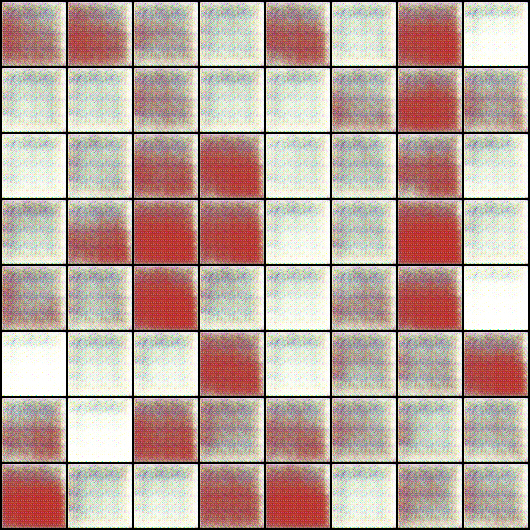

In [132]:
Image('./generated/generated-images-0005.png')

In [133]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

Text(0.5, 1.0, 'Losses')

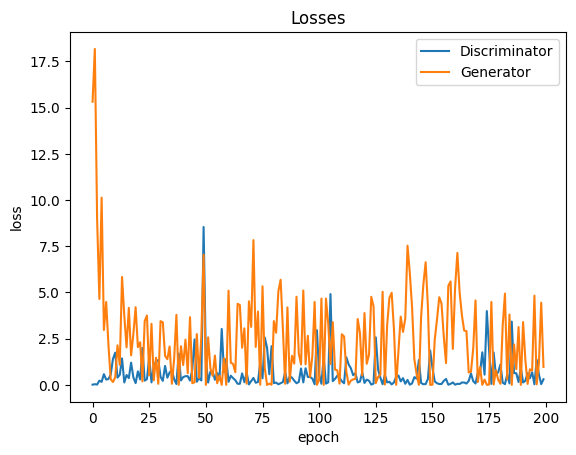

In [134]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

Text(0.5, 1.0, 'Scores')

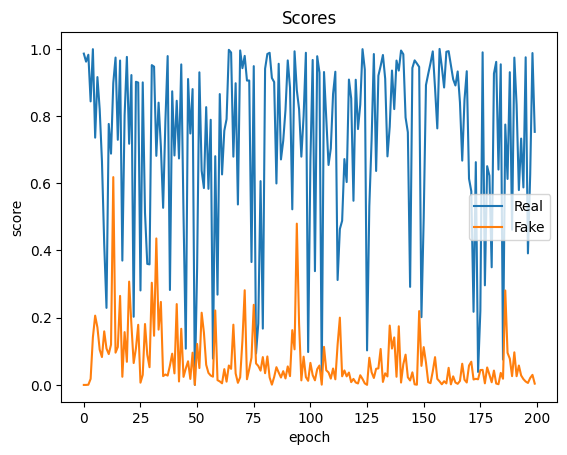

In [135]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')